Fonction qui prend en entrée {matrice de connectivité J, matrice des facteurs de correction $\alpha$, niveau de bruit pour les n noeuds} et retourne {activité cérébrale pour les n noeuds}

In [1]:
from utils_compensating_alpha import *


def generate_neural_signal(list_sigma_noise, 
                           w_graph,
                           alpha_matrix, kappa=None, gamma=None, beta=None,
                           damping=0, k=1/100
                          ):
    """
    w_graph contains all the weights w_ij = w[i,j] which relates to the pairwise factor from the probabilistic model: psi_ij(x_i,x_j) = [[w_ij, 1-w_ij], [1-w_ij, w_ij]]. No connection between node i and node j means that w_ij = 0.5
    
    damping belongs to [0,1] and corresponds to the amount of damping in the algorithm: M_{t+1} = (1-damping) * F(M_{t}) + damping * M_{t}
    k is the leak value for the definition of the neural signal with respect to the beliefs (fmri_activity = |dB/dt + k*B|)
    
    alpha_matrix is an array of size n_nodes * n_nodes (have default value for no connection = ???) which represents the loop correction factors
    kappa is an array of size n_nodes (by default array of 1) which represents the scaling of the belief
    beta is an array of size n_nodes * n_nodes (by default array of 1) which scales the connection weights J such that 2*w_ij-1=tanh(beta_ij*J_ij)
    gamma (also called w_input) is an array of size n_nodes (by default array of 1) which scales the external inputs M_ext
    
    Here we simulate extended Circular BP:
    B_i = kappa_i * (sum_j M_{j \to i} + gamma_i * M_{ext \to i})
    M_{i \to j} = arctanh(tanh(beta_{ij} * J_{ij}) * tanh(B_i - alpha_{ij} M_{j \to i}))      (where 2*w_ij-1 = tanh(beta_ij * J_ij), that is, w_ij = sig(2 * beta_ij * J_ij))
    """

    assert np.all(w_graph == w_graph.T), "w_graph (provided as input to function generate_neural_signal) is not a symmetrical matrix"
    
    #Transform 'w_graph' (matrix) into 'graph' (Networkx object) - inspired from function load_from_mat_list
    W_graph = 2 * w_graph - 1 #W_ij = 2*w_ij - 1
    graph = nx.from_numpy_matrix(W_graph) #W=0 means no edge (no possibility to indicate nonedge in nx.from_numpy_matrix --> that is why I transform w to W=2*w-1 and then go back to w by performing (W+1)/2)
    for node1, node2, d in graph.edges(data=True):
        assert 'weight' in d.keys()
        d['weight'] = (d['weight'] + 1) / 2
    assert list(graph.nodes) == list(np.arange(len(graph)))
    
    #Generate white noise using list_sigma_noise (maybe take instead a gaussian process?)
    T = 1000 #duration of the external input
    M_ext = {node: np.random.normal(0, list_sigma_noise[node], size=(T,)) for node in graph.nodes}  #same as "M_ext = generate_M_ext(type_M_ext='white_noise', graph=graph, T=1000, mean_Mext=0, stimulated_nodes='all', variance_Mext=np.array(list_sigma_noise)**2)"

    #Run extended Circular BP
    if kappa is None:
        kappa = np.ones(shape=len(graph))
    if gamma is None: #w_input
        gamma = np.ones(shape=len(graph))
    if beta is None:
        beta = np.ones(shape=(len(graph), len(graph)))
    model = Model_alpha_ij_all(graph, which_CI='CIpower_approx', which_alpha='directed_ratio', which_w='undirected', which_Mext='nodal',
                               damping=damping)
    w = w_graph #"w = get_w_matrix(graph)" would be equivalent
    #assert np.allclose(w, get_w_matrix(graph), atol=1e-15) #np.all(w == get_w_matrix(graph))
    w_eff = transf_w_power(w, beta)
    p_history = model.predict([M_ext], 
                              alpha=Alpha_obj({'K_nodes_vector': 1/kappa, 'K_edges_matrix': 1/alpha_matrix}),                             
                              w=Alpha_obj({'alpha_matrix': w_eff}), 
                              w_input=gamma,
                              keep_history_beliefs=True)[0] #maybe instead run the algo directly, without the need to define a model?
    p_history = np.array(list(p_history.values()))
    
    #Transform into "neural signal: fMRI activity = |dB/dt + k*B| with B = log(p/(1-p))
    B_history = np.log(p_history / (1-p_history))
    dB_history = np.concatenate([np.zeros((B_history.shape[0],1)), B_history[:,1:]-B_history[:,:-1]], axis=1)
    neural_signal = np.abs(dB_history + k * B_history)
    
    return neural_signal #matrix of size (n_nodes, T+2)

/home/vincent/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


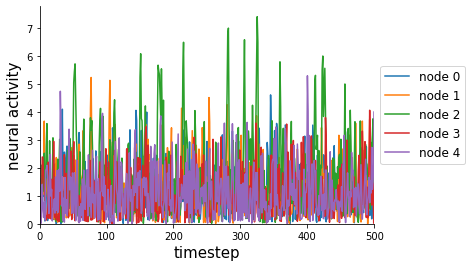

In [2]:
list_sigma_noise = np.ones(5)
w_graph = sig(np.random.normal(size=(5,5)))
w_graph = (w_graph + w_graph.T) / 2 #make the matrix symmetrical
alpha_matrix = np.random.normal(size=(5,5))
kappa = None
gamma = None
beta = None
damping = 0



activity = generate_neural_signal(list_sigma_noise, 
                                  w_graph,
                                  alpha_matrix, kappa=kappa, gamma=gamma, beta=beta,
                                  damping=damping
                                 )

#Plot the result
ax = plt.subplot(111)
for node in range(activity.shape[0]):
    plt.plot(activity[node], label='node {}'.format(node))
plt.xlabel("timestep", size=15)
plt.ylabel("neural activity", size=15)
plt.xlim(0, 500)
plt.ylim(bottom=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), prop={'size': 12})
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.show()